![TitanicNewYorkCity](./images/ex_py3_titanic_paper.jpg)

# End-to-end Machine Learning: Titanic Passengers

#### Task: Predict survival based upon available Titanic passengers list.

This notebook covers the basic Machine Learning process in Python step-by-step.

## Steps Covered
1. Importing a DataFrame
1. Visualize the Data
1. Cleanup and Transform the Data
1. Encode the Data
1. Split Training and Test Sets
1. Fine Tune Algorithms
1. Cross Validate with KFold

### CSV to DataFrame
CSV files can be loaded into a dataframe by calling `pd.read_csv` . After loading the training and test files, print a sample to see what you're working with.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df_titanic_all = pd.read_csv('./../datasets/titanic_passengers_wikipedia.csv')
df_titanic_all.sample(5)

,Pclass,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Boat,Body,Home.Dest
491,2,0,"Malachard, Mr. Noel",male,NaN,0,0,237735,15.0458,D,C,NaN,NaN,Paris
813,3,0,"Franklin, Mr. Charles (Charles Fardon)",male,NaN,0,0,SOTON/O.Q. 3101314,7.2500,NaN,S,NaN,NaN,NaN
688,3,0,"Braund, Mr. Lewis Richard",male,29.0,1,0,3460,7.0458,NaN,S,NaN,NaN,"Bridgerule, Devon"
761,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,NaN,NaN,NaN
139,1,1,"Graham, Mrs. William Thompson (Edith Junkins)",female,58.0,0,1,PC 17582,153.4625,C125,S,3,NaN,"Greenwich, CT"


### Visualizing Data
Visualizing data is crucial for recognizing underlying patterns to exploit in the model.

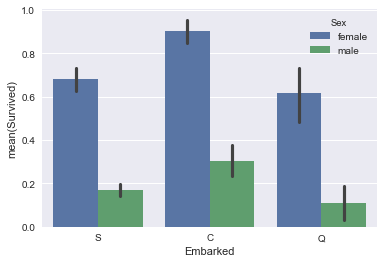

In [30]:
import seaborn as sns
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=df_titanic_all);

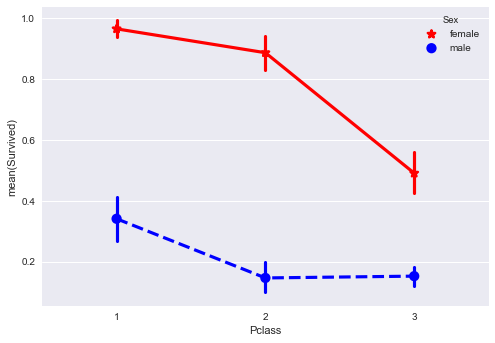

In [3]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=df_titanic_all,
              palette={"male": "blue", "female": "red"},
              markers=["*", "o"], linestyles=["-", "--"]);

### Transforming Features
1. **`simplify_ages(df)`**: Aside from 'Sex', the 'Age' feature is second in importance. To avoid overfitting, grouping people into logical human age groups.
1. **`simplify_cabins(df)`**: Each Cabin starts with a letter followed by a number, and cabin letters are more important than the number. Sliced off the numbers. See [Encyclopedia Titanica: Cabin Allocations](https://www.encyclopedia-titanica.org/cabins.html)
1. **`simplify_fares(df)`**: Fare is another continuous value than can be simplified. To get a distribution of this feature, then placed them into quartile bins accordingly.
1. **`format_name(df)`**: Extract information from the 'Name' feature. Rather than use the full name, extract the last name and name prefix (Mr. Mrs. Etc.), then appended them as their own features.
1. **`drop_features(df)`**: Drop useless features.  (Ticket, Name, Boat, Body, and Home.Dest)

In [101]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5).apply(lambda x: round(x,1))
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked', 'Boat', 'Body', 'Home.Dest'], axis=1)

def reorder_columns(df):
    return df[['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Lname','NamePrefix']]

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    df = reorder_columns(df)
    return df

df_titanic = transform_features(df_titanic_all)
df_titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,1,female,Young Adult,0,0,4_quartile,B,"Allen,",Miss.
1,1,1,male,Baby,1,2,4_quartile,C,"Allison,",Master.
2,0,1,female,Baby,1,2,4_quartile,C,"Allison,",Miss.
3,0,1,male,Young Adult,1,2,4_quartile,C,"Allison,",Mr.
4,0,1,female,Student,1,2,4_quartile,C,"Allison,",Mrs.


### Create Modeling Training and Prediction Test Dataframes
Splitting the available data

In [102]:
df_titanic = df_titanic.reindex(np.random.permutation(df_titanic.index)).reset_index(drop=True)
df_titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,0,3,male,Student,0,0,1_quartile,N,"Petroff,",Mr.
1,0,2,male,Young Adult,0,0,2_quartile,N,"Givard,",Mr.
2,0,3,male,Student,0,0,1_quartile,N,"Canavan,",Mr.
3,1,2,female,Young Adult,0,0,2_quartile,N,"Pinsky,",Mrs.
4,1,3,female,Teenager,4,2,1_quartile,N,"Andersson,",Miss.


Break randomized dataset into dataframes for 70% for training and 30% for test.

In [103]:
df_train=df_titanic.sample(frac=0.70,random_state=200).reset_index(drop=True)
df_test=df_titanic.drop(df_train.index).reset_index(drop=True)

df_train['PassengerId'] = range(1, len(df_train) + 1)
df_test['PassengerId'] = range(len(df_train) + 1, len(df_train) + len(df_test) + 1)

cols = list(df_train.columns.values)
cols.pop(cols.index('PassengerId'))
df_train = df_train[['PassengerId']+cols]
df_test = df_test[['PassengerId']+cols]

df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,1,1,male,Adult,1,1,4_quartile,E,"Spedden,",Mr.
1,2,1,2,male,Baby,1,1,3_quartile,N,"Wells,",Master.
2,3,0,3,male,Teenager,1,0,2_quartile,N,"Chronopoulos,",Mr.
3,4,0,3,male,Unknown,0,0,1_quartile,N,"Fox,",Mr.
4,5,0,2,male,Adult,1,0,3_quartile,N,"Hold,",Mr.


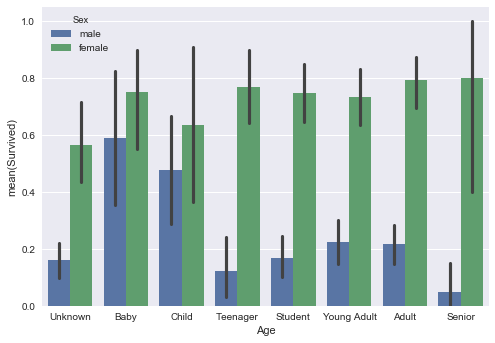

In [7]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=df_train);

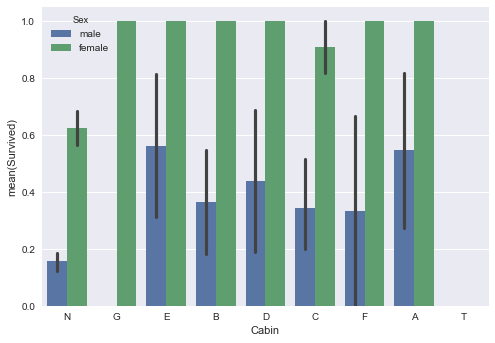

In [8]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=df_train);

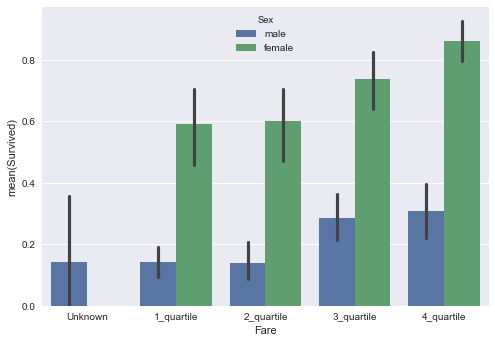

In [9]:
sns.barplot(x="Fare", y="Survived", hue="Sex", data=df_train);

### More Encoding
Last part of preprocessing phase is to normalize labels. The [`LabelEncoder`](http://scikit-learn.org/stable/modules/preprocessing_targets.html#label-encoding) in [**scikit-learn**](http://scikit-learn.org/stable/index.html) will convert each unique string value into a number, making out data more flexible for various algorithms.

In [104]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
df_train, df_test = encode_features(df_train, df_test)
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,1,1,1,0,1,1,3,4,631,18
1,2,1,2,1,1,1,1,2,7,696,12
2,3,0,3,1,5,1,0,1,7,129,18
3,4,0,3,1,6,0,0,0,7,222,18
4,5,0,2,1,0,1,0,2,7,298,18


### Splitting up the Training Data
Here we begin machine learning.
First, separate the features(X) from the labels(y).

| Value | Description |
|:-----:|:------------|
| `X_all` | All features minus the value we want to predict (Survived). |
| `y_all` | Only the value we want to predict. | 

Second, use [**scikit-learn**](http://scikit-learn.org/stable/index.html) to randomly shuffle this data into four variables. In this case, training with 80% of the data, then testing against the other 20%.

[`train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

| Variable | Type | Description |
|:---------|:----:|:------------|
| test_size | float, int, None, optional | If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. |
| random_state |  int, RandomState instance or None, optional (default=None) | If int, random_state is the seed used by the random number generator |

In [105]:
from sklearn.model_selection import train_test_split

X_all = df_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = df_train['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

### Create Model: Fitting and Tuning an Algorithm
Figure out which algorithm is going to deliver the best model. Starting [`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), but others could have been used [`Support Vector Machines`](http://scikit-learn.org/stable/modules/svm.html) or [`Naive Bayes`](http://scikit-learn.org/stable/modules/naive_bayes.html).

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

print("Training model, wait...")
# Choose the type of classifier. 
forest = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], # The number of trees in the forest.
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(forest, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the forest to the best combination of parameters
forest = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
forest.fit(X_train, y_train)
print("Completed training model")
print(forest)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [107]:
y_predictions = forest.predict(X_test)
print(accuracy_score(y_test, y_predictions))

0.798913043478


### Validate Model with KFold
Validate generated model by verifying its the effectiveness of the algorithm using [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html). To do this, split data into 10 buckets, then run the algorithm using a different bucket as the test set for each iteration.

In [86]:
from sklearn.model_selection import KFold

def run_kfold(clf):
    kf = KFold(n_splits=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(X_all):
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(forest)

Fold 1 accuracy: 0.8478260869565217
Fold 2 accuracy: 0.8586956521739131
Fold 3 accuracy: 0.6847826086956522
Fold 4 accuracy: 0.8260869565217391
Fold 5 accuracy: 0.8152173913043478
Fold 6 accuracy: 0.8043478260869565
Fold 7 accuracy: 0.7252747252747253
Fold 8 accuracy: 0.8021978021978022
Fold 9 accuracy: 0.8241758241758241
Fold 10 accuracy: 0.8681318681318682
Mean Accuracy: 0.805673674151935


### Make Predictions against Test Data

In [87]:
df_test_predict = df_test.copy()

y_ids = df_test_predict['PassengerId']
df_test_predict = df_test_predict.drop(['PassengerId', 'Survived'], axis=1)

df_test_predict.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,1,6,0,0,3,0,562,16
1,3,1,0,2,0,1,7,251,16
2,1,1,7,0,0,2,2,67,16
3,3,1,6,8,2,3,7,582,16
4,2,0,7,1,1,3,7,181,17


In [88]:
y_predictions = forest.predict(df_test_predict)

df_predictions = pd.DataFrame({ 'PassengerId' : y_ids, 'Survived': y_predictions })
df_predictions.head()

,PassengerId,Survived
0,917,0
1,918,0
2,919,0
3,920,0
4,921,1


In [89]:
y_test = df_test['Survived']
prediction_accuracy = accuracy_score(y_test, y_predictions)
print(prediction_accuracy)

0.819338422392


Feature ranking:
1. feature Sex [1] (0.392350)
2. feature NamePrefix [8] (0.299639)
3. feature Cabin [6] (0.135835)
4. feature Pclass [0] (0.066836)
5. feature SibSp [3] (0.034397)
6. feature Fare [5] (0.027070)
7. feature Lname [7] (0.026688)
8. feature Parch [4] (0.013379)
9. feature Age [2] (0.003806)


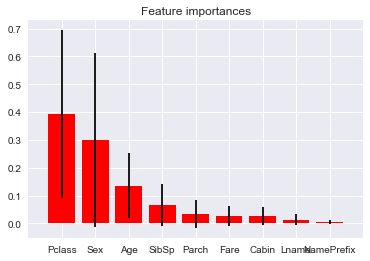

In [90]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

feature_names = list(X_train.columns)

for f in range(X_train.shape[1]):
    print("%d. feature %s [%d] (%f)" % (f + 1, X_train.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.xticks(range(X_train.shape[1]), feature_names)
plt.show()

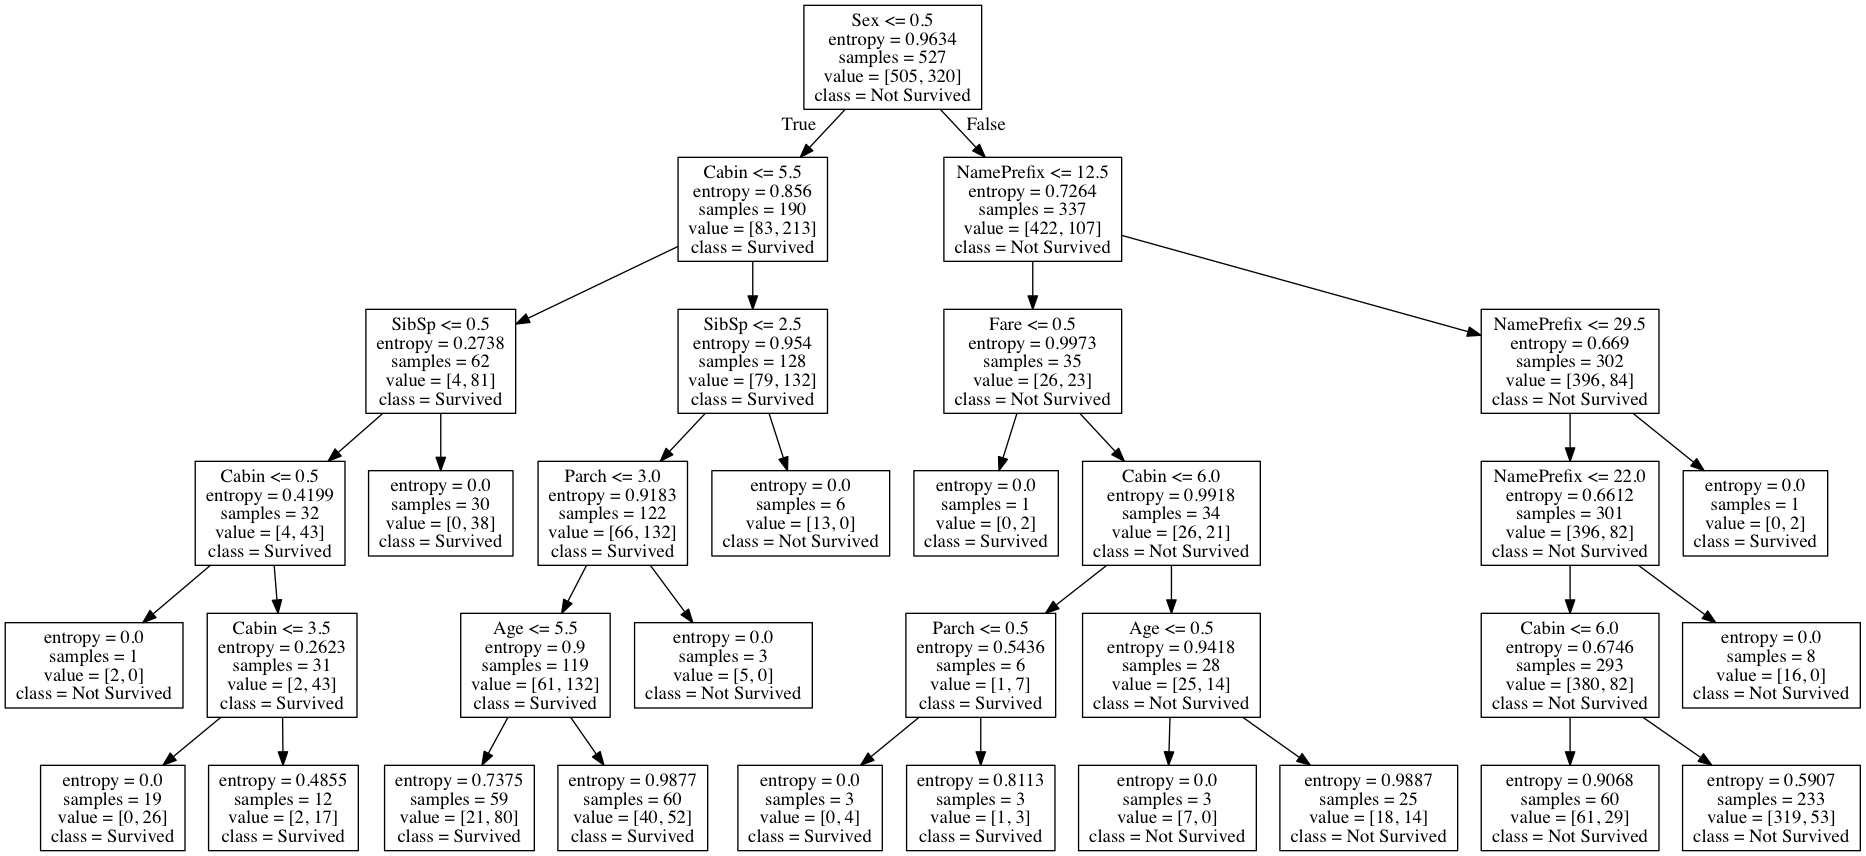

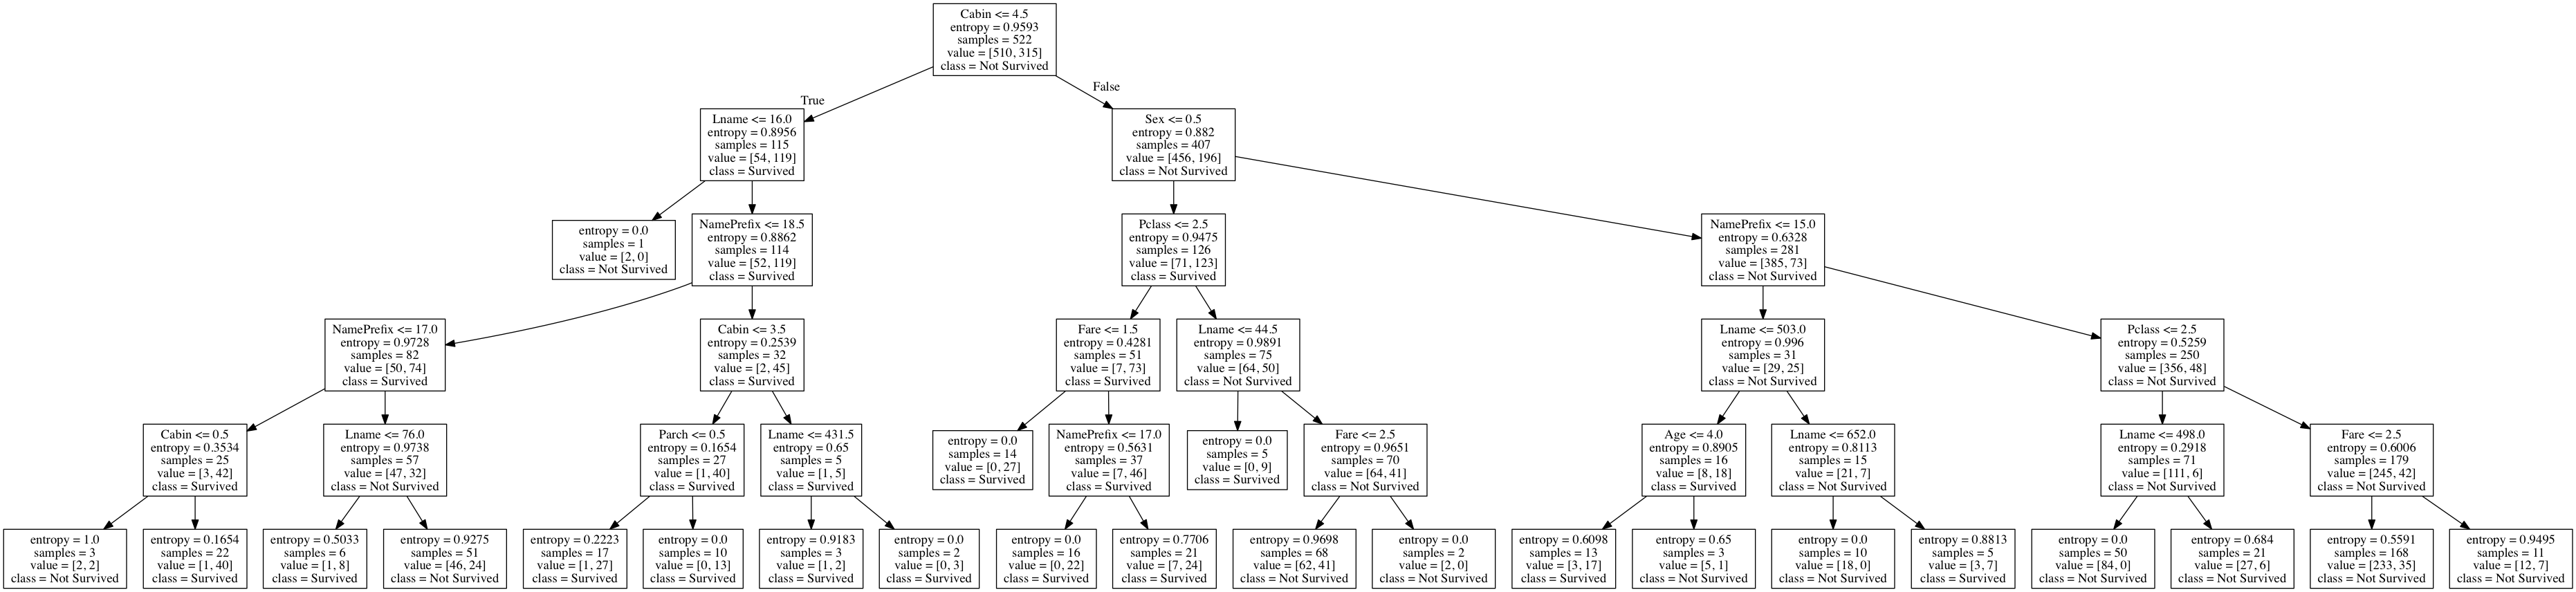

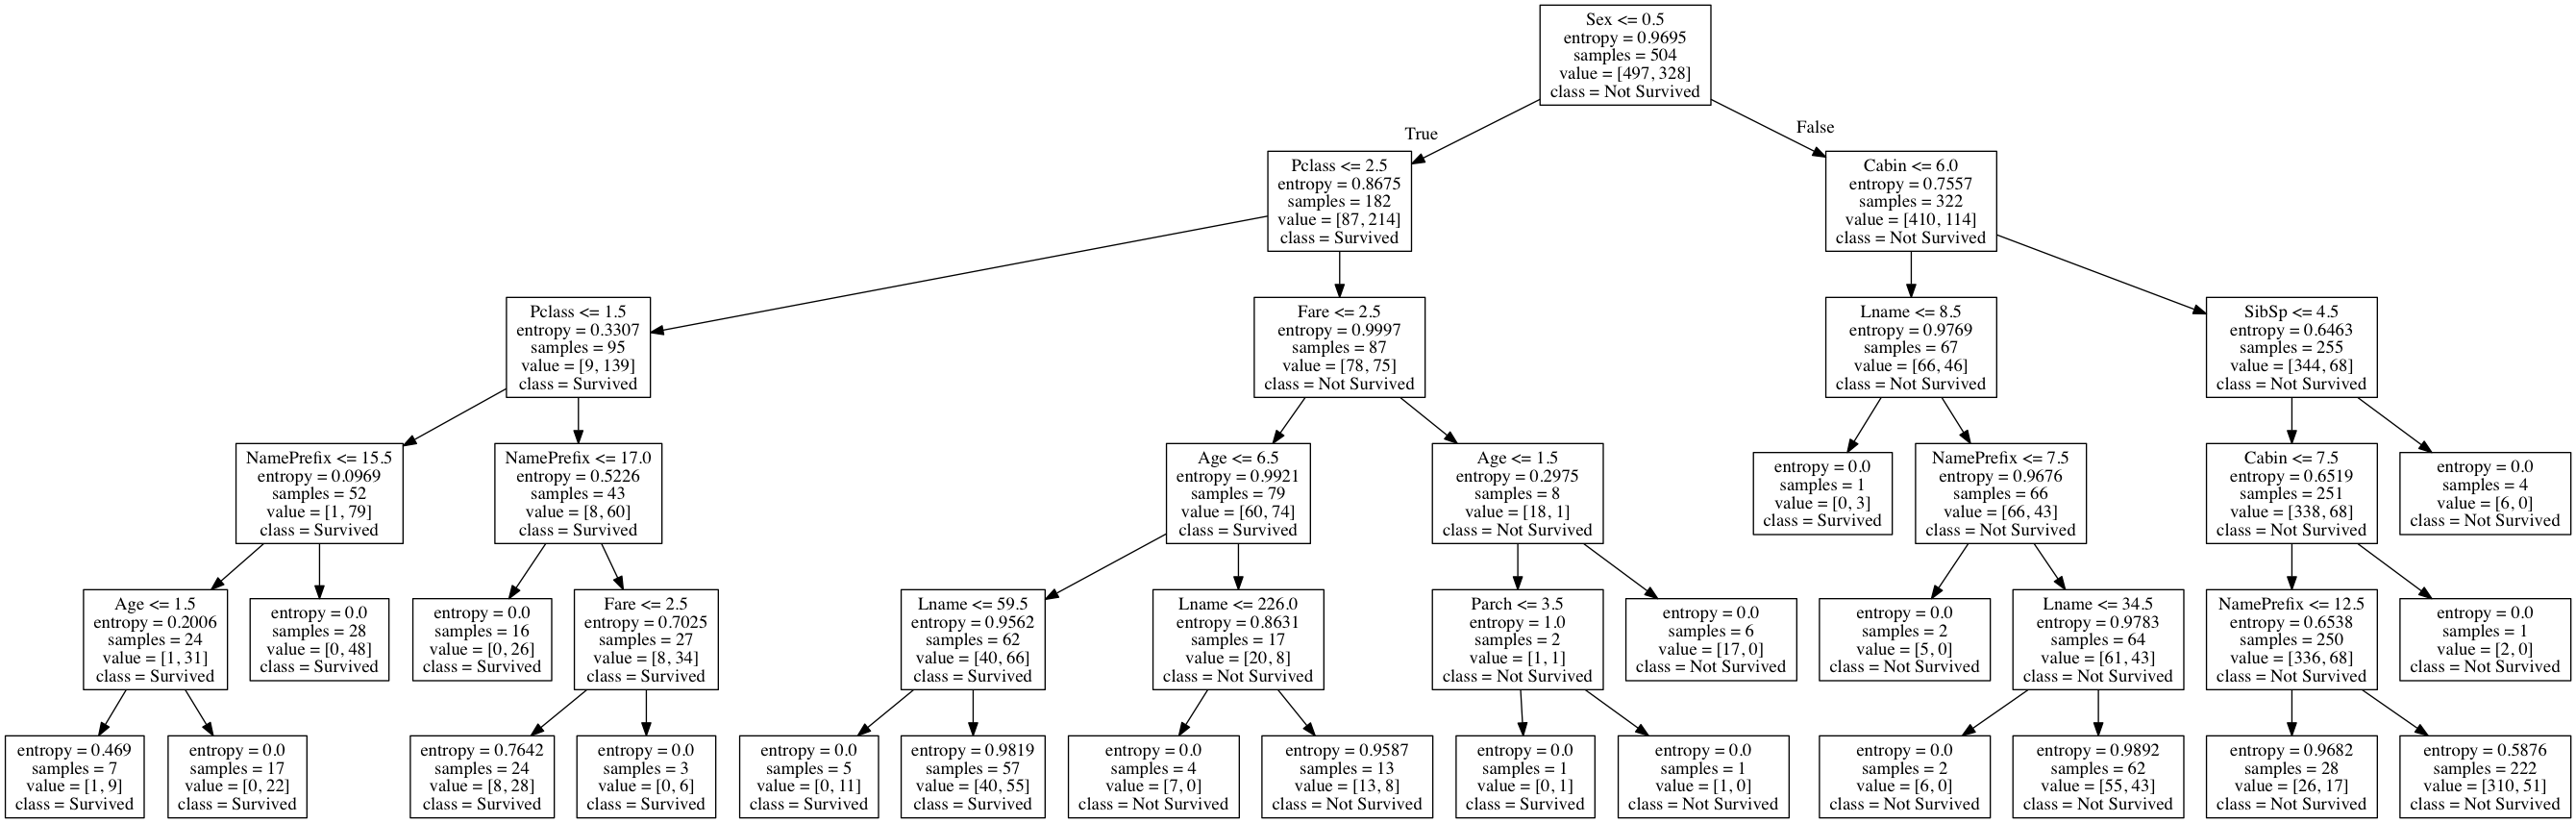

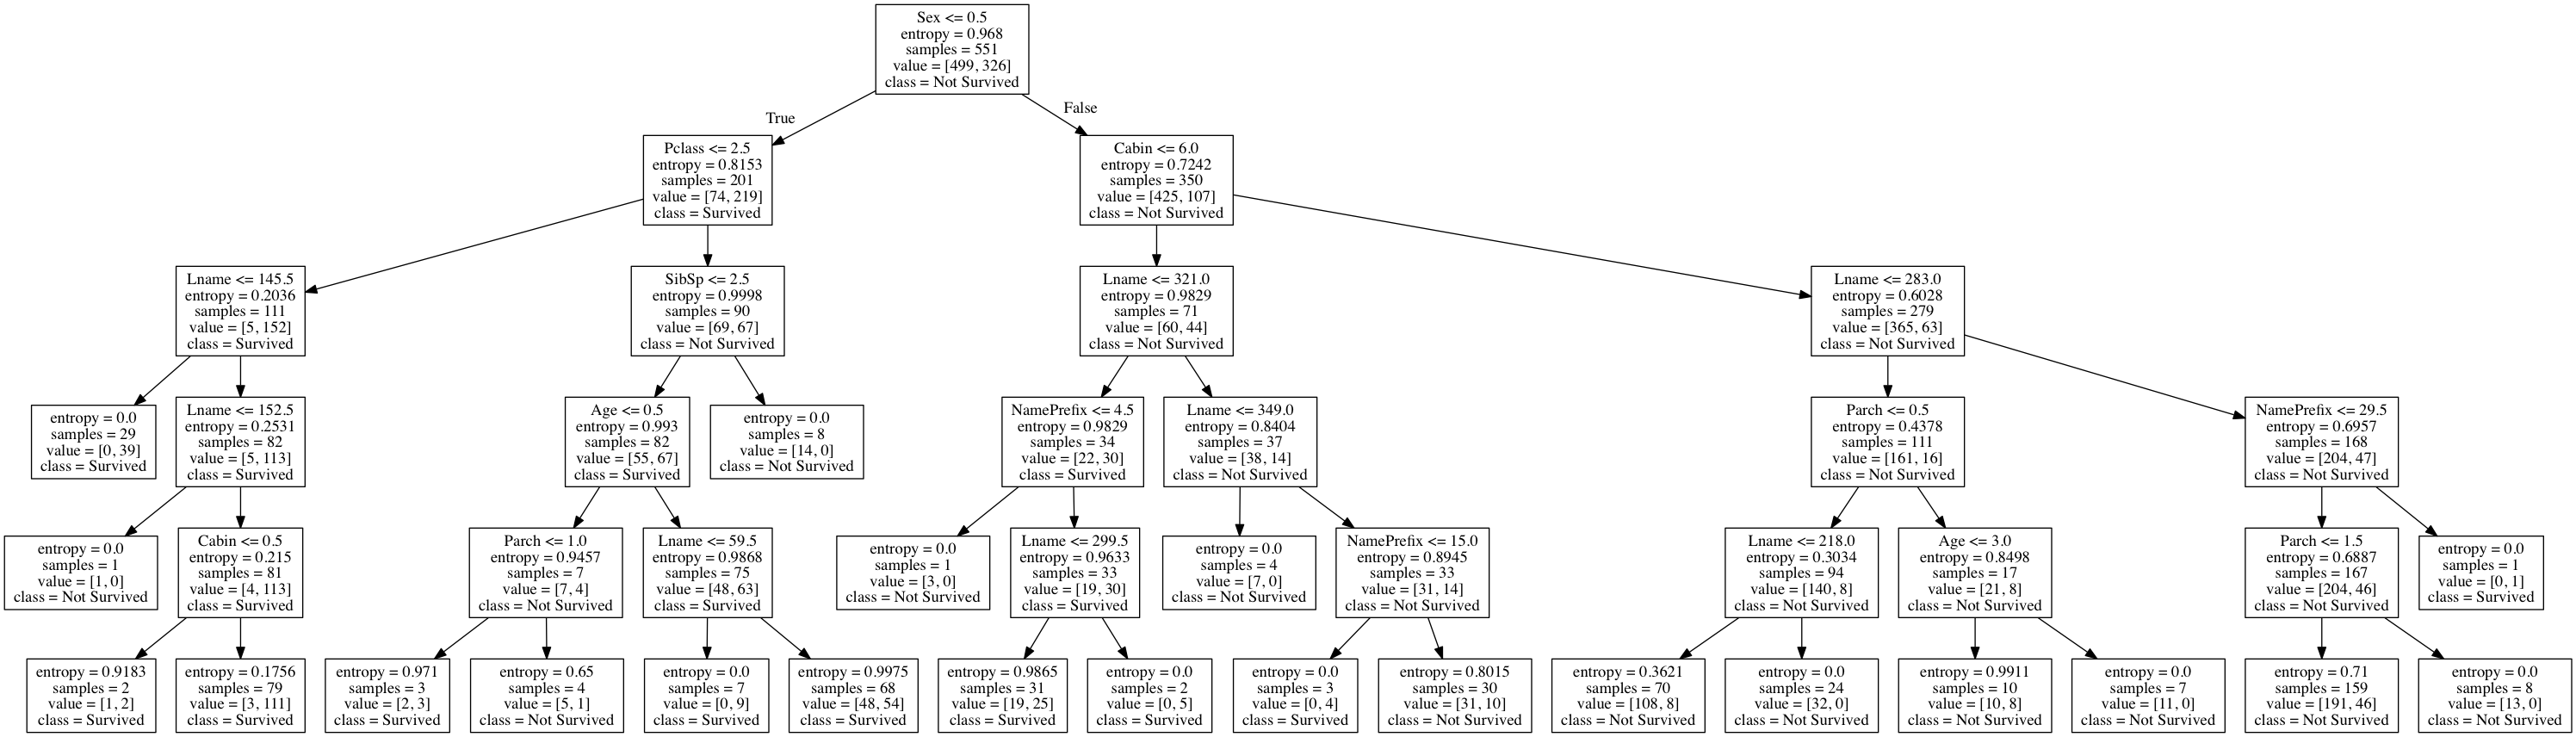

In [20]:
# Visualize
# from scikit decision tree tutorial: http://scikit-learn.org/stable/modules/tree.html
from sklearn import tree
from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image
from IPython.display import display

feature_names = list(X_train.columns)
class_names = ['Not Survived', 'Survived']

i_tree = 0
for tree_in_forest in forest.estimators_:
    dot_data = StringIO()
    tree.export_graphviz(tree_in_forest, out_file=dot_data, feature_names=feature_names, class_names=class_names)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    image = Image(graph.create_png())
    display(image)
    i_tree = i_tree + 1
